# Correct Sample Selection Bias (CSSB)

We borrow intuitions from the following paper:
```
@inproceedings{NIPS2006_a2186aa7,
 author = {Huang, Jiayuan and Gretton, Arthur and Borgwardt, Karsten and Sch\"{o}lkopf, Bernhard and Smola, Alex},
 booktitle = {Advances in Neural Information Processing Systems},
 editor = {B. Sch\"{o}lkopf and J. Platt and T. Hoffman},
 pages = {},
 publisher = {MIT Press},
 title = {Correcting Sample Selection Bias by Unlabeled Data},
 url = {https://proceedings.neurips.cc/paper_files/paper/2006/file/a2186aa7c086b46ad4e8bf81e2a3a19b-Paper.pdf},
 volume = {19},
 year = {2006}
}
```
The paper is also available [here](./res/Correcting%20Sample%20Selection%20Bias%20by%20Unlabeled%20Data.pdf).

### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchinfo import summary

from torch.utils.tensorboard import SummaryWriter

np.random.seed(0)
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
import _base_model
import _dataloader_helper

#### For logging multiple runs

In [3]:
import pathlib

log_root = pathlib.Path(f'./cssb')
run_id = 1
while True:
    log_dir = log_root/f'run{run_id}'
    if not log_dir.exists():
        break
    run_id += 1

# use a previous run
# log_dir = log_root/'run1'
log_dir.mkdir(parents=True, exist_ok=True)
print(f'Logging to: {log_dir}')

Logging to: cssb\run1


### Prepare dataset

Here, we transform both the source and target datasets into the same size, and repeat the channel dimension for grayscale images, such that both datasets have the same input shape to the model.

In [4]:
input_shape = (3, 32, 32)
num_classes = 10

loader_helper = _dataloader_helper.MNIST2USPS(image_size=input_shape[1:])
src_train, src_val, src_test = loader_helper.get_src_loaders()
tgt_train, tgt_val, tgt_test = loader_helper.get_tgt_loaders()

#### Visualize some samples from both domains

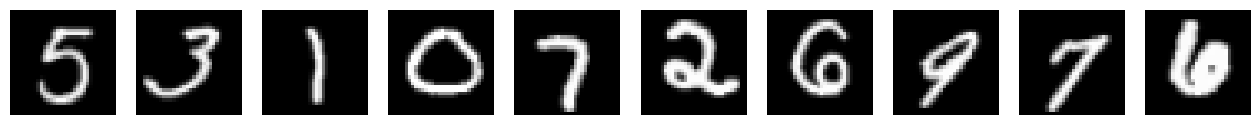

torch.Size([10, 3, 32, 32])
tensor([5, 3, 1, 0, 7, 2, 6, 9, 7, 6])


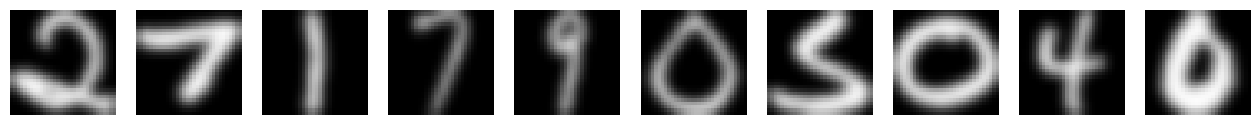

torch.Size([10, 3, 32, 32])
tensor([2, 7, 1, 7, 9, 0, 5, 0, 4, 0])


In [5]:
num_samples = 10

src_samples = next(iter(src_train))
tgt_samples = next(iter(tgt_train))

src_images, src_labels = src_samples[0][:num_samples], src_samples[1][:num_samples]
tgt_images, tgt_labels = tgt_samples[0][:num_samples], tgt_samples[1][:num_samples]

def plot_samples(samples, figsize=(16, 6)):
    fig, ax = plt.subplots(1, num_samples, figsize=figsize)
    for i in range(num_samples):
        ax[i].imshow(np.transpose(samples[i], (1, 2, 0)))
        ax[i].axis('off')
    plt.show()

plot_samples(src_images)
print(src_images.shape)
print(src_labels)

plot_samples(tgt_images)
print(tgt_images.shape)
print(tgt_labels)

## Idea

The idea of our implementation here is simple. For a task, say classification, we aim to minimize the following expected loss (risk) on the target domain:
\begin{align*}
\mathbb{E}_{(x, y) \sim p_\mathcal{T}(x, y)} \left[ L(f(x), y) \right]
\end{align*}
where $p_\mathcal{T}(x, y)$ is the joint distribution of the input and output in the target domain, and $f$ is the model.

We only have access to the source domain labels, and thus $y$ is not directly available in the Monte Carlo estimate of the above expectation which is taken w.r.t. $p_\mathcal{T}(x, y)$. We can however, under the assumption of no concept shift, i.e. $p_\mathcal{T}(y | x) = p_\mathcal{S}(y | x)$, rewrite the above expectation as follows:
\begin{align*}
\mathbb{E}_{(x, y) \sim p_\mathcal{T}(x, y)} \left[ L(f(x), y) \right]
    &= \int \int L(f(x), y) p_\mathcal{T}(x, y) \, dx \, dy \\
    &= \int \int L(f(x), y) \frac{ p_\mathcal{T}(x, y) }{ p_\mathcal{S}(x, y) } p_\mathcal{S}(x, y) \, dx \, dy \\
    &= \int \int L(f(x), y) \frac{ p_\mathcal{T}(y | x) p_\mathcal{T}(x) }{ p_\mathcal{S}(y | x) p_\mathcal{S}(x) } p_\mathcal{S}(x, y) \, dx \, dy \\
    &= \int \int L(f(x), y) \frac{ p_\mathcal{T}(x) }{ p_\mathcal{S}(x) } p_\mathcal{S}(x, y) \, dx \, dy \\
    &= \mathbb{E}_{(x, y) \sim p_\mathcal{S}(x, y)} \left[ \frac{ p_\mathcal{T}(x) }{ p_\mathcal{S}(x) } L(f(x), y) \right]
\end{align*}

Furthermore, we can treat the domain itself as a random variable, and write $p_\mathcal{T}(x)$ and $p_\mathcal{S}(x)$ as follows:
\begin{align*}
p_\mathcal{T}(x) &= p(x | \mathcal{T}) = \frac{ p(\mathcal{T} | x) p(x) }{ p(\mathcal{T}) } \\
p_\mathcal{S}(x) &= p(x | \mathcal{S}) = \frac{ p(\mathcal{S} | x) p(x) }{ p(\mathcal{S}) }
\end{align*}
where we applied the bayes rule on the RHS and $p(x)$ is the marginal distribution of the input regardless of the domain.

Finally, if we further assume $p(\mathcal{T}) = p(\mathcal{S})$ then:
\begin{align*}
\mathbb{E}_{(x, y) \sim p_\mathcal{T}(x, y)} \left[ L(f(x), y) \right]
    &= \mathbb{E}_{(x, y) \sim p_\mathcal{S}(x, y)} \left[ \frac{ p(\mathcal{T} | x) }{ p(\mathcal{S} | x) } L(f(x), y) \right]
\end{align*}

Thus, we can estimate $p(\mathcal{T} | x)$ and $p(\mathcal{S} | x)$ using a domain classifier, and reweight the loss using their ratio to obtain the Monte Carlo estimate of the expected loss on the target domain.

### Build our model

In [6]:
model = _base_model.CNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes
).to(device)

domain_classifier = _base_model.FCHead(
    input_shape=input_shape,
    op_out_features=2
)

print(summary(model, input_size=(5, *input_shape)))
print(summary(domain_classifier, input_size=(5, *input_shape)))

Layer (type:depth-idx)                   Output Shape              Param #
CNNClassifier                            [5, 10]                   --
├─CNNEncoder: 1-1                        [5, 128, 2, 2]            --
│    └─ModuleList: 2-1                   --                        --
│    │    └─Sequential: 3-1              [5, 64, 15, 15]           1,792
│    │    └─Sequential: 3-2              [5, 128, 6, 6]            73,856
│    │    └─Sequential: 3-3              [5, 128, 2, 2]            147,584
├─FCHead: 1-2                            [5, 10]                   --
│    └─ModuleList: 2-2                   --                        --
│    │    └─Sequential: 3-4              [5, 3072]                 1,575,936
│    │    └─Sequential: 3-5              [5, 2048]                 6,293,504
│    │    └─Linear: 3-6                  [5, 10]                   20,490
Total params: 8,113,162
Trainable params: 8,113,162
Non-trainable params: 0
Total mult-adds (M): 121.73
Input size (MB): 0.06

### Train the domain classifier

In [7]:
def evaluate_domain_cls(
    domain_cls_model,
    src_loader,
    tgt_loader,
    loss_fn
):
    training = domain_cls_model.training
    val_loss = 0
    val_acc = 0

    len_src_loader = len(src_loader)
    len_tgt_loader = len(tgt_loader)
    len_loader = min(len_src_loader, len_tgt_loader)

    src_loader_iter = iter(src_loader)
    tgt_loader_iter = iter(tgt_loader)

    N_total = 0

    domain_cls_model.eval()
    with torch.no_grad():
        for batch in range(len_loader):
            x_src, _ = next(src_loader_iter)
            x_tgt, _ = next(tgt_loader_iter)

            x = torch.cat((x_src, x_tgt), dim=0)
            x = x.to(device)

            y = torch.cat((
                torch.full((x_src.shape[0],), 0, dtype=torch.long),
                torch.full((x_tgt.shape[0],), 1, dtype=torch.long)
            ))
            y = y.to(device)

            y_pred = domain_cls_model(x)
            
            loss = loss_fn(y_pred, y).item()
            n_correct = (y_pred.argmax(dim=1) == y).sum().item()

            N = x_src.shape[0] + x_tgt.shape[0]
            val_loss += loss * N
            val_acc += n_correct
            N_total += N
    domain_cls_model.train(training)
    
    val_loss /= N_total
    val_acc /= N_total
    return (val_loss, val_acc)

def train_domain_cls(
    domain_cls_model,
    src_loader,
    tgt_loader,
    src_val_loader,
    tgt_val_loader,
    optimizer,
    loss_fn,
    num_steps=20000,
    checkpoint=100,
):
    domain_cls_model.train()

    train_stats = []
    val_stats = []
    best_val_loss = float('inf')

    src_loader_iter = iter(src_loader)
    tgt_loader_iter = iter(tgt_loader)

    tb_writer = SummaryWriter(log_dir=log_dir)

    for step in tqdm(range(num_steps)):
        try:
            src_x, _ = next(src_loader_iter)
        except StopIteration:
            src_loader_iter = iter(src_loader)
            src_x, _ = next(src_loader_iter)
        try:
            tgt_x, _ = next(tgt_loader_iter)
        except StopIteration:
            tgt_loader_iter = iter(tgt_loader)
            tgt_x, _ = next(tgt_loader_iter)

        x = torch.cat((src_x, tgt_x), dim=0)
        x = x.to(device)

        # src domain samples are labeled 0, tgt domain samples are labeled 1
        y = torch.cat((
            torch.full((src_x.shape[0],), 0, dtype=torch.long),
            torch.full((tgt_x.shape[0],), 1, dtype=torch.long)
        ))
        y = y.to(device)

        y_pred = domain_cls_model(x)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % checkpoint == 0:
            val_loss, val_acc = evaluate_domain_cls(
                domain_cls_model,
                src_val_loader,
                tgt_val_loader,
                loss_fn
            )

            train_stats += [[
                step,
                loss.item(),
            ]]
            val_stats += [[
                step,
                val_loss,
                val_acc
            ]]

            tb_writer.add_scalar('domain_cls/train/loss', loss.item(), step)
            tb_writer.add_scalar('domain_cls/val/loss', val_loss, step)
            tb_writer.add_scalar('domain_cls/val/acc', val_acc, step)

            # save the best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(domain_cls_model.state_dict(), log_dir/'domain_cls.pth')
    
    tb_writer.close()

    train_stats = np.array(train_stats)
    val_stats = np.array(val_stats)
    return (train_stats, val_stats)

In [8]:
train_stats, val_stats = train_domain_cls(
    domain_classifier,
    src_train,
    tgt_train,
    src_val,
    tgt_val,
    optimizer=torch.optim.Adam(domain_classifier.parameters(), lr=1e-4),
    loss_fn=nn.CrossEntropyLoss(),
    num_steps=1000,
    checkpoint=100,
)

100%|██████████| 1000/1000 [00:51<00:00, 19.45it/s]


#### Learning curves

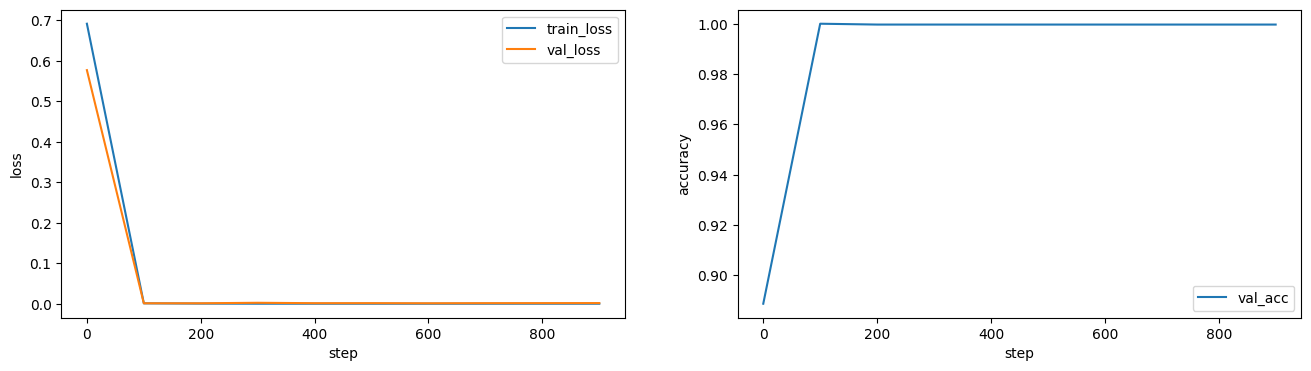

In [9]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(train_stats[:, 0], train_stats[:, 1], label='train_loss')
plt.plot(val_stats[:, 0], val_stats[:, 1], label='val_loss')
plt.legend()
plt.xlabel('step')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(val_stats[:, 0], val_stats[:, 2], label='val_acc')
plt.legend()
plt.xlabel('step')
plt.ylabel('accuracy')
plt.show()

#### Evaluate the best model

In [10]:
domain_classifier.load_state_dict(torch.load(log_dir/'domain_cls.pth'))

val_loss, val_acc = evaluate_domain_cls(
    domain_classifier,
    src_test,
    tgt_test,
    nn.CrossEntropyLoss()
)
print('Domain classifier:')
print(f'test -> loss: {val_loss:.4f}, acc: {val_acc:.4f}')

# freeze the domain classifier
for param in domain_classifier.parameters():
    param.requires_grad = False

Domain classifier:
test -> loss: 0.0011, acc: 0.9998


### Train the actual model

In [11]:
def evaluate(model, val_loader, loss_fn):
    val_loss = 0
    val_acc = 0

    training = model.training
    model.eval()
    with torch.no_grad():
        for batch, (x, y) in enumerate(val_loader):
            x, y = x.to(device), y.to(device)
            y_pred, _ = model(x)
            loss = loss_fn(y_pred, y).item()
            n_correct = (y_pred.argmax(dim=1) == y).sum().item()
            val_loss += loss * x.shape[0]
            val_acc += n_correct
    model.train(training)
    
    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)
    return (val_loss, val_acc)

def train(
    model,
    domain_classifier,
    src_loader,
    tgt_loader,
    src_val_loader,
    tgt_val_loader,
    optimizer,
    loss_fn,
    num_steps=20000,
    betas=(1e-2, 1e2),
    checkpoint=100,
):
    domain_classifier.eval()
    model.train()

    train_stats = []
    val_stats = []
    best_val_loss = float('inf')

    src_loader_iter = iter(src_loader)
    tgt_loader_iter = iter(tgt_loader)

    tb_writer = SummaryWriter(log_dir=log_dir)

    for step in tqdm(range(num_steps)):
        try:
            src_x, src_y = next(src_loader_iter)
        except StopIteration:
            src_loader_iter = iter(src_loader)
            src_x, src_y = next(src_loader_iter)
        try:
            tgt_x, tgt_y = next(tgt_loader_iter)
        except StopIteration:
            tgt_loader_iter = iter(tgt_loader)
            tgt_x, tgt_y = next(tgt_loader_iter)
        
        src_x, src_y = src_x.to(device), src_y.to(device)
        tgt_x, tgt_y = tgt_x.to(device), tgt_y.to(device)

        src_y_pred, _ = model(src_x)
        tgt_y_pred, _ = model(tgt_x)

        # note that we do not use tgt_y
        p_pred = F.softmax(domain_classifier(src_x), dim=-1)
        p_S = p_pred[:, 0]
        p_T = p_pred[:, 1]
        beta = p_T / p_S
        beta = torch.clip(beta, min=betas[0], max=betas[1])

        per_sample_loss = loss_fn(src_y_pred, src_y)

        assert per_sample_loss.ndim > 0, (
            f'per_sample_loss has shape {per_sample_loss.shape}, which is incompatible with shape of beta {beta.shape}.\n'
            'Ensure that the loss function returns a scalar loss per sample (reduction="none").'
        )

        loss = beta * per_sample_loss
        loss = torch.mean(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % checkpoint == 0:
            mean_log_beta = torch.mean(torch.log(beta))

            src_val_loss, src_val_acc = evaluate(model, src_val_loader, nn.CrossEntropyLoss())
            tgt_val_loss, tgt_val_acc = evaluate(model, tgt_val_loader, nn.CrossEntropyLoss())

            train_stats += [[
                step,
                loss.item(),
                mean_log_beta.item()
            ]]
            val_stats += [[
                step,
                src_val_loss,
                src_val_acc,
                tgt_val_loss,
                tgt_val_acc
            ]]

            tb_writer.add_scalar('train/loss', loss.item(), step)
            tb_writer.add_scalar('train/mean_log_beta', mean_log_beta.item(), step)

            tb_writer.add_scalar('val/src_loss', src_val_loss, step)
            tb_writer.add_scalar('val/src_acc', src_val_acc, step)
            tb_writer.add_scalar('val/tgt_loss', tgt_val_loss, step)
            tb_writer.add_scalar('val/tgt_acc', tgt_val_acc, step)

            # save the best model
            # this may be cheating since in reality the target dataset is unlabeled
            if tgt_val_loss < best_val_loss:
                best_val_loss = tgt_val_loss
                torch.save(model.state_dict(), log_dir/'tgt_best_model.pth')
    
    tb_writer.close()

    train_stats = np.array(train_stats)
    val_stats = np.array(val_stats)
    return (train_stats, val_stats)

In [12]:
train_stats, val_stats = train(
    model,
    domain_classifier,
    src_train,
    tgt_train,
    src_val,
    tgt_val,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-4),
    loss_fn=nn.CrossEntropyLoss(reduction='none'),
    num_steps=5000,
    betas=(1e-2, 1e2),
    checkpoint=100,
)

100%|██████████| 5000/5000 [05:38<00:00, 14.75it/s]


#### Learning curves

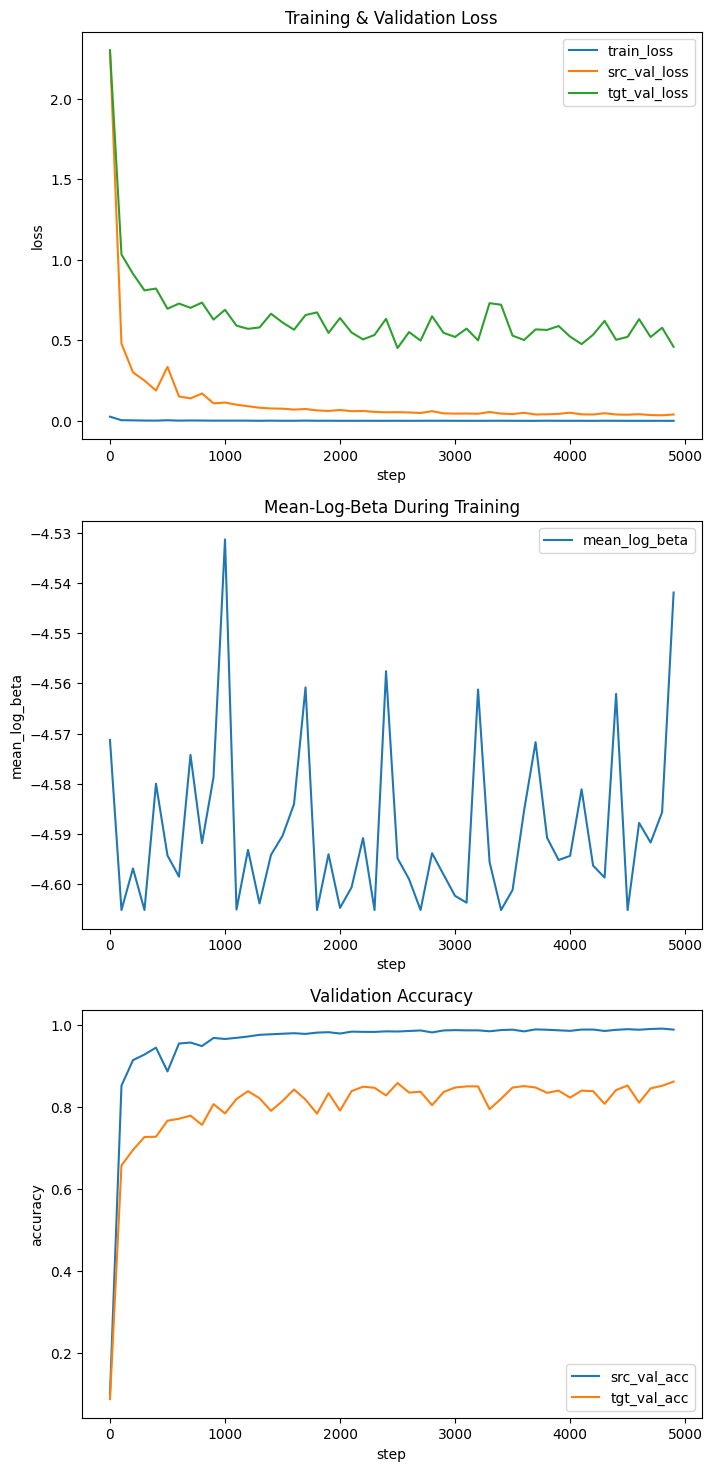

In [13]:
plt.figure(figsize=(8, 18))
plt.subplot(3, 1, 1)
plt.plot(train_stats[:, 0], train_stats[:, 1], label='train_loss')
plt.plot(val_stats[:, 0], val_stats[:, 1], label='src_val_loss')
plt.plot(val_stats[:, 0], val_stats[:, 3], label='tgt_val_loss')
plt.legend()
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Training & Validation Loss')

plt.subplot(3, 1, 2)
plt.plot(train_stats[:, 0], train_stats[:, 2], label='mean_log_beta')
plt.legend()
plt.xlabel('step')
plt.ylabel('mean_log_beta')
plt.title('Mean-Log-Beta During Training')

plt.subplot(3, 1, 3)
plt.plot(val_stats[:, 0], val_stats[:, 2], label='src_val_acc')
plt.plot(val_stats[:, 0], val_stats[:, 4], label='tgt_val_acc')
plt.legend()
plt.xlabel('step')
plt.ylabel('accuracy')
plt.title('Validation Accuracy')
plt.show()

#### Evaluate the best model

In [14]:
model.load_state_dict(torch.load(log_dir/'tgt_best_model.pth'))

src_loss, src_acc = evaluate(model, src_test, nn.CrossEntropyLoss())
tgt_loss, tgt_acc = evaluate(model, tgt_test, nn.CrossEntropyLoss())

print('Adapted model:')
print(f'src_test -> loss: {src_loss:.4f}, acc: {src_acc:.4f}')
print(f'tgt_test -> loss: {tgt_loss:.4f}, acc: {tgt_acc:.4f}')

Adapted model:
src_test -> loss: 0.0423, acc: 0.9865
tgt_test -> loss: 0.5104, acc: 0.8361
